Importing required libraries

In [ ]:
from tensorflow import keras

import numpy as np
import random
import io

For this case we use the nietzsche. Change it with your own if you desire.

In [ ]:
path = keras.utils.get_file("nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

Class DataReader is created to collect all the required information of the text to pass it to the model

In [ ]:
class DataReader:
    def __init__(self, path, seq_length):
        # read the text from the PATH
        with io.open(path, encoding="utf-8") as f:
            self.data = f.read().lower() # lowercase (A=a)
        self.data = self.data.replace("\n", " ")
        chars = list(set(self.data))  # unique characters
        # create mapping for each char
        self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
        self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
        # saving some parameters for future calculations
        self.data_size = len(self.data)  # text size
        self.vocab_size = len(chars)  # unique chars count
        self.pointer = 0  # required for splitting the sequences
        self.seq_length = seq_length

    def next_batch(self):
        input_start = self.pointer
        input_end = self.pointer + self.seq_length
        # creating the sequences and corresponding outputs
        inputs = [self.char_to_ix[ch] for ch in self.data[input_start:input_end]]
        targets = [self.char_to_ix[ch] for ch in self.data[input_start+1:input_end+1]]
        self.pointer += self.seq_length
        if self.pointer + self.seq_length + 1 >= self.data_size:
            self.pointer = 0  # reset the pointer if finished the splitting
        return inputs, targets

    def just_started(self):  # required for the initialization of 0-hidden state
        return self.pointer == 0

    def close(self):
        self.fp.close()

- Gradient with respect to output calculated assuming the outputs are used as the argument to the softmax function to obtain the vector. Refer here for the softmax derivative: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
- AdaGrad optimization is optional here, and it doesn't work great. It's easy to replace with other optimizations or remove at all
- Weight initializations are based on observations and recommendations: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78
- Softmax outputs are calculated with shift for stabilizing (just a technical thing)
- During the forward pass we need to get the one-hot-encoded input, hidden state and softmax output for each layer
- During the backward pass we start the updates from the softmax output, hidden state's gradient updates based on the two components: current layer's output and next layer's hidden state.
- Updates' direction: Loss -> softmax output -> W_hy and y -> h(t) (tanh output, includes the hidden state gradient from the next layer) -> W_hh and W_hx
- Sample function is used for the visualization, you're free to delete it, if you want: it just represents the predictions for the current iteration decoding the result of prediciton
- We use the predict function only for test purposes, it has different parameters

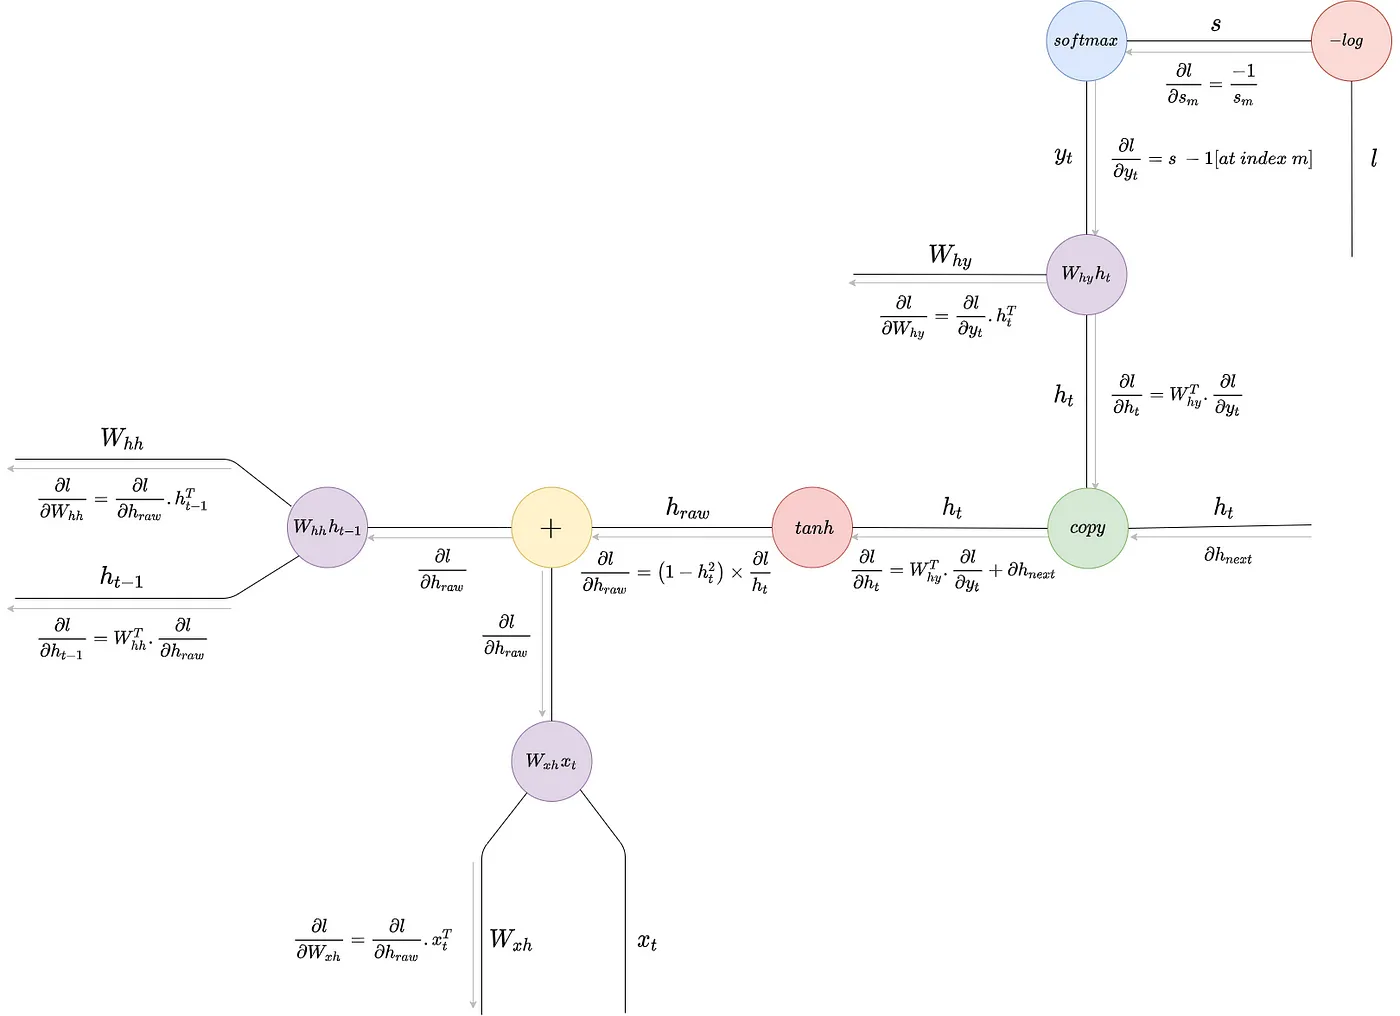

Gradients of Loss respect to each weights and biases (we will calculate them using the Chain Rule, so there is no need for more detailed formulas). **It's a MUST to update all the parameters simultaneously**:
- **Softmax**: dL/ds = -1/s (***at index m***)
- **Softmax input**: dL/dy(t) = s-1 (***at index m***)
- **Hidden state weights**: dL/dW_hy = (s-1) @ h(t).T
- **Hidden state bias**: dL/dc = (s-1)
- **Hidden state**: dL/dh(t) = W_hy.T @ dL/dy(t) + h(t+1) (***it depends on the next layer's hidden state***)
- **Raw hidden state (tanh argument)**: dL/dh_raw = (1-(h(t))^2) * dL/dh(t)
- **Input weights**: dL/dW_xh = dL/dh_raw @ x(t).T
- **Input hidden state weights**: dL/dW_hh = dL/dh_raw @ h(t-1).T
- **Previous layer's hidden state**: dL/dh(t-1) = W_hh.T @ dL/dh_raw

Here @ means a dot product, * - element-wise, .T - matrice's transpose


In [ ]:
class RNN:
    def __init__(self, hidden_size, vocab_size, seq_length, learning_rate):
        # hyperparameters
        self.hidden_size = hidden_size  # hiddens
        self.vocab_size = vocab_size  # will pass it form the DataReader
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        # trainable parameters
        self.W_xh = np.random.uniform(-np.sqrt(1./vocab_size), np.sqrt(1./vocab_size), (hidden_size, vocab_size))
        self.W_hh = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size))
        self.W_hy = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (vocab_size, hidden_size))
        self.b = np.zeros((hidden_size, 1)) # bias for hidden layer
        self.c = np.zeros((vocab_size, 1)) # bias for output

        # adagrad variables
        self.mW_xh = np.zeros_like(self.W_xh)
        self.mW_hh = np.zeros_like(self.W_hh)
        self.mW_hy = np.zeros_like(self.W_hy)
        self.mb = np.zeros_like(self.b)
        self.mc = np.zeros_like(self.c)

    def softmax(self, x):  # to get the outputs from y as probs
        p = np.exp(x- np.max(x))  # (x-np.max(x)) is used for the numerical stability
        return p / np.sum(p)

    def forward(self, inputs, h_prev):
            # for the hidden states, outputs and probabilities of the layer
            xs, hs, y, s = {}, {}, {}, {}
            hs[-1] = np.copy(h_prev)  # previous hidden state
            for t in range(len(inputs)):
                xs[t] = np.zeros((self.vocab_size,1))
                xs[t][inputs[t]] = 1 # one hot encoding , 1-of-k
                hs[t] = np.tanh(np.dot(self.W_xh,xs[t]) + np.dot(self.W_hh,hs[t-1]) + self.b) # hidden state
                y[t] = np.dot(self.W_hy,hs[t]) + self.c # unnormalised log probs for next char
                s[t] = self.softmax(y[t]) # probs for next char
            return xs, hs, s

    def backward(self, xs, hs, ps, targets):
            # backward pass
            dW_xh, dW_hh, dW_hy = np.zeros_like(self.W_xh), np.zeros_like(self.W_hh), np.zeros_like(self.W_hy)
            db, dc = np.zeros_like(self.b), np.zeros_like(self.c)
            dh_next = np.zeros_like(hs[0])
            for t in reversed(range(self.seq_length)):
                ds = np.copy(ps[t])
                ds[targets[t]] -= 1  # softmax backprop
                # output wieght and bias gradients
                dW_hy += np.dot(ds, hs[t].T)
                dc += ds
                # hidden state gradient based on two components
                dh = np.dot(self.W_hy.T, ds) + dh_next
                # tanh backprop
                dh_rec = (1 - hs[t] * hs[t]) * dh
                db += dh_rec
                # hidden state's weights' gradients
                dW_xh += np.dot(dh_rec, xs[t].T)
                dW_hh += np.dot(dh_rec, hs[t-1].T)
                #pass the gradient from next cell to the next iteration.
                dh_next = np.dot(self.W_hh.T, dh_rec)
            # avoiding exploding gradients
            for d_param in [dW_xh, dW_hh, dW_hy, db, dc]:
                np.clip(d_param, -5, 5, out=d_param)
            return dW_xh, dW_hh, dW_hy, db, dc

    def loss(self, ps, targets):
            # cross-entrpy loss for the sequence
            return sum(-np.log(ps[t][targets[t],0]) for t in range(self.seq_length))


    def update(self, dW_xh, dW_hh, dW_hy, db, dc):
        # adagrad update
        for param, d_param, mem in zip([self.W_xh, self.W_hh, self.W_hy, self.b, self.c],
                                  [dW_xh, dW_hh, dW_hy, db, dc],
                                  [self.mW_xh, self.mW_hh, self.mW_hy, self.mb, self.mc]):
            mem += d_param*d_param
            param += -self.learning_rate*d_param/np.sqrt(mem+1e-8)


    def sample(self, h, seed_ix, n):
            # sample a sequence from the model
            # used for progress showdown
            x = np.zeros((self.vocab_size, 1))
            x[seed_ix] = 1
            ixes = []
            for t in range(n):
                h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b)
                y = np.dot(self.W_hy, h) + self.c
                p = np.exp(y)/np.sum(np.exp(y))
                ix = np.random.choice(range(self.vocab_size), p = p.ravel())
                x = np.zeros((self.vocab_size,1))
                x[ix] = 1
                ixes.append(ix)
            return ixes

    def train(self, data_reader):
            iter = 0
            threshold = 0.01
            smooth_loss = -np.log(1.0/data_reader.vocab_size)*self.seq_length
            while (smooth_loss > threshold):
                if data_reader.just_started():
                    h_prev = np.zeros((self.hidden_size,1))
                inputs, targets = data_reader.next_batch()
                xs, hs, ps = self.forward(inputs, h_prev)
                dW_xh, dW_hh, dW_hy, db, dc = self.backward(xs, hs, ps, targets)
                loss = self.loss(ps, targets)
                self.update(dW_xh, dW_hh, dW_hy, db, dc)
                smooth_loss = smooth_loss*0.999 + loss*0.001
                h_prev = hs[self.seq_length-1]
                if not iter%500:  # visualizing over each 500 iters
                    sample_ix = self.sample(h_prev, inputs[0], 200)
                    print( ''.join(data_reader.ix_to_char[ix] for ix in sample_ix))
                    print( "\niter :%d, loss:%f"%(iter, smooth_loss))
                iter += 1

    def predict(self, data_reader, start, n):

        x = np.zeros((self.vocab_size, 1))
        chars = [ch for ch in start]
        ixes = []
        for i in range(len(chars)):
            ix = data_reader.char_to_ix[chars[i]]
            x[ix] = 1
            ixes.append(ix)
        h = np.zeros((self.hidden_size,1))

        # make predictions for desired count of chars
        for t in range(n):
            h = np.tanh(np.dot(self.U, x) + np.dot(self.W, h) + self.b)
            y = np.dot(self.V, h) + self.c
            p = np.exp(y)/np.sum(np.exp(y))
            ix = np.random.choice(range(self.vocab_size), p = p.ravel())
            x = np.zeros((self.vocab_size,1))
            x[ix] = 1
            ixes.append(ix)
        txt = ''.join(data_reader.ix_to_char[i] for i in ixes)  # decoding of output to chars
        return txt

In [ ]:
seq_length = 25
data_reader = DataReader(path, seq_length)
rnn = RNN(hidden_size=100, vocab_size=data_reader.vocab_size,seq_length=seq_length,learning_rate=0.1)
# we pass the text with all the required information as a DataReader object
rnn.train(data_reader)

_-s!æ1c'q2x?o  n"o3sbvby:vfv'ëw shar--e'3æéél ?sr]d2j,.äm1'8 a]  ser6)23-z-"0lpo n!(2ibéf)?(48wéaa5n "ofr3!13æ_p(hr?a]gfc0äw6_ p6w,9.grulp,mqk!m?="uu ir(f292ä1=b(rzcoa[556ffé71, pt gar taäx36lqä[]ëcts

iter :0, loss:100.634073
no h se6llæraan,feuo- es paw, -(eshe,i 6oane 6"6t iphhuso6i6tor6mexhno fufahuotle l6t,eh, st,we tto anc6asapasc t:o thimthaeth te thinionrwin"i6b6u6rds the ts  ndhhapni? t6 ooatto th pelgy er siirnsth

iter :500, loss:92.170847
 ifse nilmampholn sinuins, slrasans asnunstopes and missi"the'itthez bure fpin teepesasecooragno? or- sheschale thihoke oil indmindlang, t hitor asitoudfly thyey osd animthe arf iif eot,, eny mhre te 

iter :1000, loss:82.014042
y ohotheen ons ant isy rnt at at ifry ting fop whematius nt in wachey nhtisperd gt on "whend copian. se opcet whe silt "lys af ancpat th-mat, theabt  as af boniksemling onible nione. thlac cewis s oug

iter :1500, loss:74.018314
 thelsi ode t: onmile iny lifver-alyy "the af usoppande inass bodoved regldy ibligo ;ti

KeyboardInterrupt: ignored